# Manager report

In [1]:
import duckdb

duckdb_path = "data/sakila.duckdb"

dfs = {}

with duckdb.connect(duckdb_path) as conn:
    # I use information_schema.tables to get just the refined schema tables
    tables = conn.sql("SELECT table_name FROM information_schema.tables WHERE table_schema = 'refined'").df()

    for name in tables["table_name"]:
        dfs[name] = conn.sql(f"FROM refined.{name};").df()
        duckdb.register(name, dfs[name])
    
duckdb.sql("DESC;").df()

,database,schema,name,column_names,column_types,temporary
0,temp,main,actor,"[actor_id, actor_name, film_id, title, categor...","[BIGINT, VARCHAR, BIGINT, VARCHAR, VARCHAR, VA...",True
1,temp,main,customer,"[customer_id, first_name, last_name, customer_...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, VARCHAR, B...",True
2,temp,main,film,"[film_id, title, category, description, releas...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, VARCHAR, B...",True
3,temp,main,inventory,"[inventory_id, store_id, store_name, film_id, ...","[BIGINT, BIGINT, VARCHAR, BIGINT, VARCHAR, VAR...",True
4,temp,main,rental_pay,"[customer_id, customer_name, rental_id, rental...","[BIGINT, VARCHAR, BIGINT, TIMESTAMP, BIGINT, T...",True
5,temp,main,staff,"[staff_id, first_name, last_name, staff_name, ...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, VARCHAR, B...",True
6,temp,main,store,"[store_id, store_name, manager, email, address...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, VARCHAR, V...",True


1. a) Which movies are longer than 3 hours (180 minutes), show the title and its length?

In [2]:
film_len180 = duckdb.sql("""
    SELECT
        title,
        length
    FROM
        film
    WHERE
        length > 180;
""").df()


film_len180.index = film_len180.index + 1
film_len180.head()

,title,length
1,ANALYZE HOOSIERS,181
2,BAKED CLEOPATRA,182
3,CATCH AMISTAD,183
4,CHICAGO NORTH,185
5,CONSPIRACY SPIRIT,184


1. b) Which movies have the word "love" in its title? Show the following columns
- Note: Only movies that have the word "love" is on the list. This means that movies with "lovely" will not be a part of the list.

In [3]:
import pandas as pd

pd.set_option("display.max_colwidth", None)

film_love = duckdb.sql("""
    SELECT
        title,
        rating,
        length,
        description
    FROM
        film
    WHERE
        title LIKE '% LOVE' OR
        title LIKE 'LOVE %' OR
        title LIKE '% LOVE %';
""").df()

film_love.index = film_love.index + 1
film_love

,title,rating,length,description
1,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And a Hunter who must Build a Composer in Berlin
2,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodile who must Meet a Database Administrator in The Outback
3,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad Scientist who must Kill a Astronaut in An Abandoned Fun House
4,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator And a Mad Cow who must Pursue a Womanizer in Berlin
5,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explorer who must Pursue a Dentist in An Abandoned Fun House


1. c) Calculate descriptive statistics on the length column

In [4]:
film_length = duckdb.sql("""
    SELECT
        MIN(length) AS Shortest_min,
        AVG(length)::INT AS Average_min,
        MEDIAN(length)::INT AS Median_min,
        MAX(length) AS Longest_min
    FROM
        film;
""").df()

film_length

,Shortest_min,Average_min,Median_min,Longest_min
0,46,115,114,185


1. d)  The 10 most expensive movies to rent per day

In [5]:

film_dayrent = duckdb.sql("""
    SELECT
        title,
        round((rental_rate / rental_duration),2) AS Rent_per_day
    FROM
        film
    ORDER BY
        Rent_per_day DESC,
        title ASC
    LIMIT
        10;
""").df()

film_dayrent.index = film_dayrent.index + 1
film_dayrent

,title,Rent_per_day
1,ACE GOLDFINGER,1.66
2,AMERICAN CIRCUS,1.66
3,AUTUMN CROW,1.66
4,BACKLASH UNDEFEATED,1.66
5,BEAST HUNCHBACK,1.66
6,BEHAVIOR RUNAWAY,1.66
7,BILKO ANONYMOUS,1.66
8,CARIBBEAN LIBERTY,1.66
9,CASPER DRAGONFLY,1.66
10,CASUALTIES ENCINO,1.66


1. e)  Which actors have played in most movies?

In [6]:
most_movies = duckdb.sql("""                         
    SELECT
        actor_name,
        COUNT(*) AS Nr_films
    FROM actor
    GROUP BY
        actor_name
    ORDER BY
        Nr_films DESC
    LIMIT
        10;
""").df()

most_movies.index = most_movies.index + 1
most_movies

,actor_name,Nr_films
1,SUSAN DAVIS,54
2,GINA DEGENERES,42
3,WALTER TORN,41
4,MARY KEITEL,40
5,MATTHEW CARREY,39
6,SANDRA KILMER,37
7,SCARLETT DAMON,36
8,VIVIEN BASINGER,35
9,UMA WOOD,35
10,ANGELA WITHERSPOON,35


1. f)  Write down 3-5 questions you want to answer and then answer them using pandas and duckdb.
    - To be able to buy some new movies and removing som old movies i want to know.
        1. Which category generates the most revenue relative to the number of films we have in that category? 
        2. Which Top 5 actors is the most popular in the category that has the best revenue/film?
        3. What are the bottom 10 films in terms of the least revenue generated?


In [8]:
most_rev_cat = duckdb.sql("""
        SELECT
            category,
            COUNT(DISTINCT inventory_id) AS nr_film,
            COUNT(inventory_id) AS rental_film,
            SUM(amount) AS revenue,
            ROUND(SUM(amount) / COUNT(DISTINCT inventory_id),2) AS Rev_Film
        FROM
            rental_pay
        GROUP BY
            category
        ORDER BY
            Rev_Film DESC
        LIMIT 10;
""").df()

most_rev_cat.index = most_rev_cat.index + 1
most_rev_cat.head()

,category,nr_film,rental_film,revenue,Rev_Film
1,Comedy,269,941,4383.58,16.30
2,New,275,940,4351.62,15.82
3,Games,276,969,4281.33,15.51
4,Sports,344,1179,5314.21,15.45
5,Drama,300,1060,4587.39,15.29


As you can se the Sports-category makes more money but it could be caused by the big numbers of films in that category. The category that has de biggest rev per film are the Comedy-category. So we should invest in more Comedys.

In [ ]:
Top5_actor = duckdb.sql("""                        
    SELECT
        category,
        actor_name,
        COUNT(actor_id) AS nr_films
    FROM
        actor
    WHERE
        category = 'Comedy'
    GROUP BY
        actor_name,
        category
    ORDER BY
        nr_films DESC,
        actor_name ASC
    LIMIT
        5;
""").df()

Top5_actor.index = Top5_actor.index + 1
Top5_actor.head()

,category,actor_name,nr_films
1,Comedy,BELA WALKEN,6
2,Comedy,RIVER DEAN,5
3,Comedy,RUSSELL TEMPLE,5
4,Comedy,ANGELINA ASTAIRE,4
5,Comedy,BEN WILLIS,4


So we should buy some Comedy-films with some of theas actors.

In [ ]:
least_rev_film = duckdb.sql("""
    SELECT
        title AS film,
        COUNT(DISTINCT inventory_id) AS nr_films,
        COUNT(rental_id) AS nr_rental,
        SUM(amount) AS revenue
    FROM
        rental_pay
    GROUP BY
        film
    ORDER BY
        revenue ASC,
        nr_rental ASC
    LIMIT
        10;
""").df()

least_rev_film.index = least_rev_film.index + 1
least_rev_film.head()

,film,nr_films,nr_rental,revenue
1,OKLAHOMA JUMANJI,2,6,5.94
2,TEXAS WATCH,2,6,5.94
3,FREEDOM CLEOPATRA,2,5,5.95
4,DUFFEL APOCALYPSE,2,7,6.93
5,YOUNG LANGUAGE,2,7,6.93


So we should get rid of some of these films when we buy new ones.

2. a)  Who are our top 5 customers by total spend?

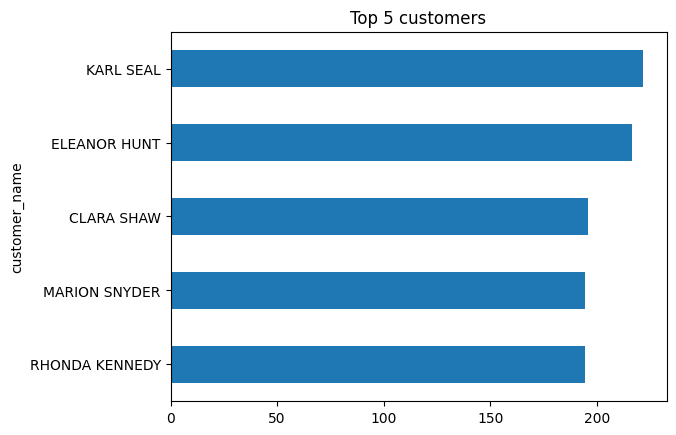

In [ ]:
top5_customers = duckdb.sql("""
    SELECT
        customer_id,
        customer_name,
        SUM(amount) AS total_spend
    FROM
        rental_pay
    GROUP BY
        customer_name,
        customer_id
    ORDER BY
        total_spend DESC
    LIMIT
        5;
""").df()

ax = top5_customers.plot (kind = "barh", x = "customer_name", y = "total_spend", title="Top 5 customers", legend=False)
ax.invert_yaxis()

2. b)  How much money does each film category bring in? Make a bar chart showing total revenue per film
category.

,category,total_sum
0,Sports,5314.21
1,Sci-Fi,4756.98
2,Animation,4656.30
3,Drama,4587.39
4,Comedy,4383.58
5,Action,4375.85
6,New,4351.62
7,Games,4281.33
8,Foreign,4270.67
9,Family,4226.07


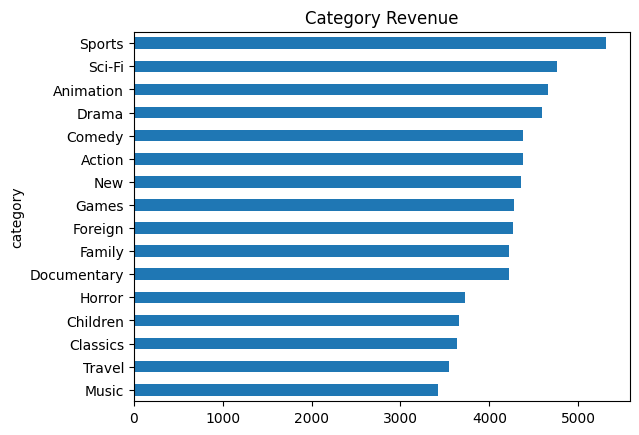

In [ ]:
rev_category = duckdb.sql("""
    SELECT
        category,
        SUM(amount) total_sum,
    FROM
        rental_pay
    GROUP BY
        category
    ORDER BY
        total_sum DESC;
""").df()

ax = rev_category.plot (kind = "barh", x = "category", y = "total_sum", title="Category Revenue", legend= False)
ax.invert_yaxis()

rev_category